In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr

from ufs2arco import sources
from ufs2arco.transforms.horizontal_regrid import get_bounds

### Get the coarsened HRRR data at 15km x 15km

In [2]:
hrrr = sources.AWSHRRRArchive(
    t0={"start": "2015-01-15T00", "end": "2015-01-15T06", "freq": "6h"},
    fhr={"start": 0, "end": 0, "step": 6},
    variables=["orog"],
)
hds = hrrr.open_sample_dataset(
    dims={"t0": hrrr.t0[0], "fhr": hrrr.fhr[0]},
    open_static_vars=True,
    cache_dir="./ufs2arco-cache",
)

hds = hds.rename({"latitude": "lat", "longitude": "lon"})
hds = get_bounds(hds)
hds = hds.rename({"x_vertices": "x_b", "y_vertices": "y_b"})

hds_bdyslice = hds.isel(
    x=slice(None, -4),
    x_b=slice(None, -4),
    y=slice(None, -4),
    y_b=slice(None, -4),
)
chds = hds_bdyslice.isel(
    x=slice(2, None, 5),
    y=slice(2, None, 5),
    x_b=slice(0, None, 5),
    y_b=slice(0, None, 5),
)

In [3]:
chds

<xarray.Dataset> Size: 3MB
Dimensions:  (t0: 1, y: 211, x: 359, y_b: 212, x_b: 360)
Coordinates:
  * t0       (t0) datetime64[ns] 8B 2015-01-15
    lat      (y, x) float64 606kB ...
    lon      (y, x) float64 606kB ...
    lat_b    (y_b, x_b) float64 611kB 21.12 21.16 21.19 ... 47.89 47.84 47.79
    lon_b    (y_b, x_b) float64 611kB 237.3 237.4 237.5 ... 298.5 298.7 298.9
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    orog     (t0, y, x) float32 303kB -0.036 -0.036 -0.036 ... -0.036 -0.036

In [4]:
ads = xr.open_zarr("/pscratch/sd/t/timothys/nested-eagle/v0/data/hrrr.forecast.zarr")
ads

<xarray.Dataset> Size: 4GB
Dimensions:               (cell: 75749, variable: 1, time: 13147, ensemble: 1)
Coordinates:
  * cell                  (cell) int64 606kB 0 1 2 3 ... 75745 75746 75747 75748
  * ensemble              (ensemble) int64 8B 0
  * time                  (time) int64 105kB 0 1 2 3 ... 13143 13144 13145 13146
  * variable              (variable) int64 8B 0
Data variables: (12/23)
    count                 (variable) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    count_array           (time, variable, ensemble) float64 105kB dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    data                  (time, variable, ensemble, cell) float32 4GB dask.array<chunksize=(1, 1, 1, 75749), meta=np.ndarray>
    dates                 (time) datetime64[s] 105kB dask.array<chunksize=(13147,), meta=np.ndarray>
    gmean_residual_stdev  (variable) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    has_nans              (variable) bool 1B dask.array<chunksize=(1,), meta=np.ndarray>
    ...                    ...
    stdev                 (variable) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    sums                  (variable) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    sums_array            (time, variable, ensemble) float64 105kB dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    t0                    (time) datetime64[ns] 105kB dask.array<chunksize=(1,), meta=np.ndarray>
    x                     (cell) int64 606kB dask.array<chunksize=(75749,), meta=np.ndarray>
    y                     (cell) int64 606kB dask.array<chunksize=(75749,), meta=np.ndarray>
Attributes: (12/16)
    allow_nans:              True
    end_date:                2024-01-31T18:00:00
    ensemble_dimension:      1
    field_shape:             [211, 359]
    flatten_grid:            True
    frequency:               6h
    ...                      ...
    stack_order:             ['y', 'x']
    start_date:              2015-02-01T06:00:00
    statistics_end_date:     2023-01-31T18:00:00
    statistics_start_date:   2015-02-01T06:00:00
    variables:               ['accum_tp']
    variables_metadata:      {'accum_tp': {'mars': {'date': '20150201', 'para...

In [5]:
len(chds.y)*len(chds.x)

75749

Cool, the math above shows we've recreated the grid being used in anemoi...

Based on the trim plots in separate notebook, I'll trim 15 points off the left coarsened HRRR domain edges, plus whatever it takes to make
the number of grid points divisible by the reduction factor.

In [6]:
trim = 15
nmc = 4
tchds = chds.isel(
    x=slice(trim, -trim-1),
    y=slice(trim, -trim-1),
    x_b=slice(trim, -trim-1),
    y_b=slice(trim, -trim-1),
)
print(len(tchds.x)/4)
print(len(tchds.y)/4)
print(tchds.lon.isel(x=0,y=0).values, tchds.lat.isel(x=0,y=0).values)
print(tchds.lon.isel(x=-1,y=-1).values, tchds.lat.isel(x=-1,y=-1).values)

82.0
45.0
238.79933574943644 23.593985793731036
294.70957081074306 46.544797176707895


In [7]:
print(tchds.lon.min().values, tchds.lat.min().values)
print(tchds.lon.max().values, tchds.lat.max().values)

229.948723649617 23.593985793731036
294.70957081074306 50.35917944342358


In [69]:
print(len(chds.x), len(tchds.x))
print(len(chds.y), len(tchds.y))
print(len(chds.x_b), len(tchds.x_b))
print(len(chds.y_b), len(tchds.y_b))

359 328
211 180
360 329
212 181


Now, let's define the mesh points with offset nmc 

So... no idea how this generalizes beyond a factor of 2 (nmc=2 in the code). But, this looks good for a first stab.

In [70]:
hmesh = tchds[["lat_b", "lon_b"]].isel(
    x_b=slice(2, None, nmc),
    y_b=slice(2, None, nmc),
).rename(
    {"lat_b": "lat", "lon_b": "lon", "x_b": "x", "y_b": "y"},
)

In [71]:
hmesh

<xarray.Dataset> Size: 59kB
Dimensions:  (y: 45, x: 82)
Coordinates:
    lat      (y, x) float64 30kB 23.83 23.96 24.09 24.22 ... 46.78 46.6 46.42
    lon      (y, x) float64 30kB 239.0 239.5 240.1 240.6 ... 292.9 293.6 294.3
Dimensions without coordinates: y, x
Data variables:
    *empty*

Double check myself.

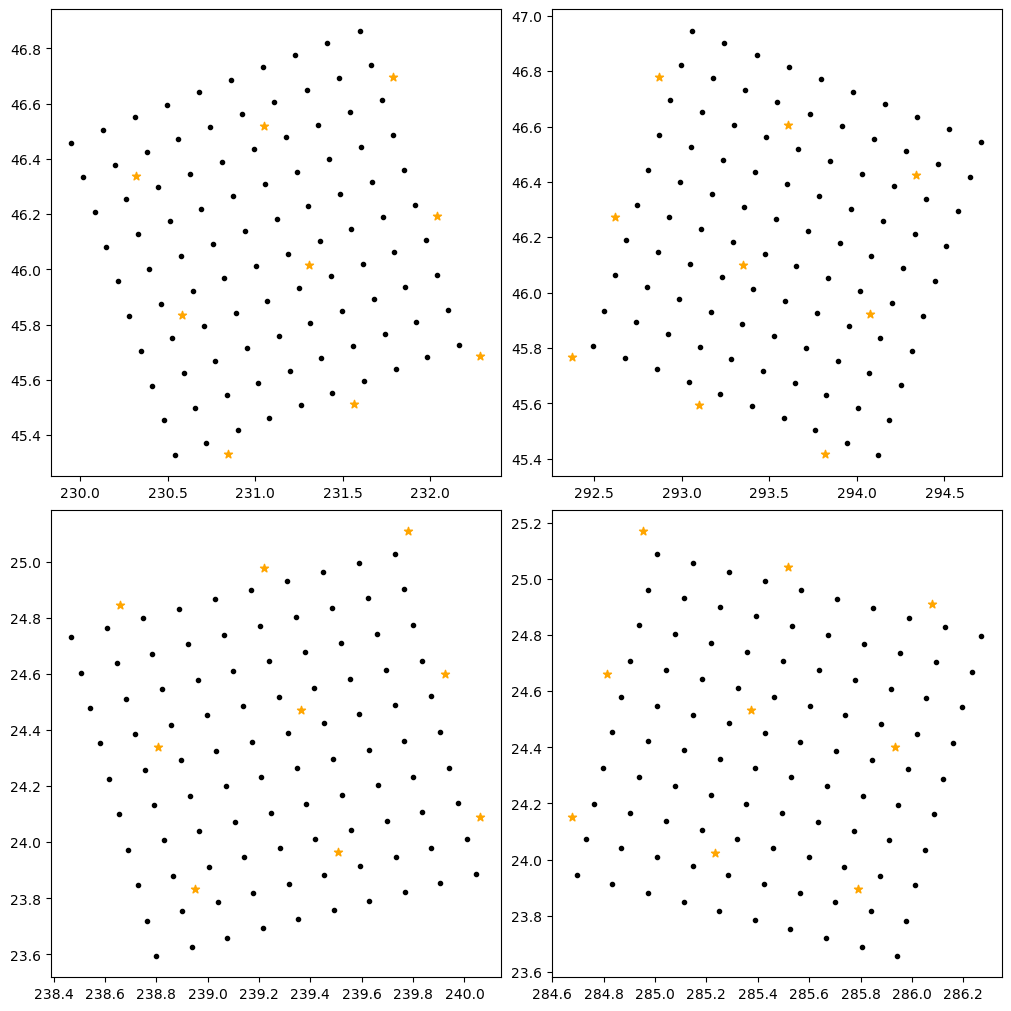

In [72]:
fig, axs = plt.subplots(2, 2, figsize=(10,10), constrained_layout=True)

for slc, slc_b, ax in zip(
    [
        {"x": slice(10), "y": slice(-10, None)},
        {"x": slice(-10, None), "y": slice(-10, None)},
        {"x": slice(10), "y": slice(10)},
        {"x": slice(-10, None), "y": slice(10)},
    ],
    [
        {"x": slice(3), "y": slice(-3, None)},
        {"x": slice(-3, None), "y": slice(-3, None)},
        {"x": slice(3), "y": slice(3)},
        {"x": slice(-3, None), "y": slice(3)},
    ],
    axs.flatten(),
):
    ax.scatter(tchds.lon.isel(**slc), tchds.lat.isel(**slc), c="black", marker=".")
    ax.scatter(hmesh.lon.isel(**slc_b), hmesh.lat.isel(**slc_b), c="orange", marker="*")

In [74]:
import xesmf

In [75]:
gds = xesmf.util.grid_global(1,1, cf=True, lon1=360)
gds = gds.drop_vars("latitude_longitude")

In [76]:
gds

<xarray.Dataset> Size: 13kB
Dimensions:     (lon: 360, bound: 2, lat: 180)
Coordinates:
  * lon         (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat         (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Dimensions without coordinates: bound
Data variables:
    lon_bounds  (lon, bound) float64 6kB 0.0 1.0 1.0 2.0 ... 359.0 359.0 360.0
    lat_bounds  (lat, bound) float64 3kB -90.0 -89.0 -89.0 ... 89.0 89.0 90.0

In [77]:
gmesh = xesmf.util.grid_global(4,4,cf=True, lon1=360)
gmesh = gmesh.drop_vars("latitude_longitude")

In [78]:
gmesh

<xarray.Dataset> Size: 3kB
Dimensions:     (lon: 90, bound: 2, lat: 45)
Coordinates:
  * lon         (lon) float64 720B 2.0 6.0 10.0 14.0 ... 346.0 350.0 354.0 358.0
  * lat         (lat) float64 360B -88.0 -84.0 -80.0 -76.0 ... 80.0 84.0 88.0
Dimensions without coordinates: bound
Data variables:
    lon_bounds  (lon, bound) float64 1kB 0.0 4.0 4.0 8.0 ... 356.0 356.0 360.0
    lat_bounds  (lat, bound) float64 720B -90.0 -86.0 -86.0 ... 86.0 86.0 90.0

In [79]:
import cartopy.crs as ccrs

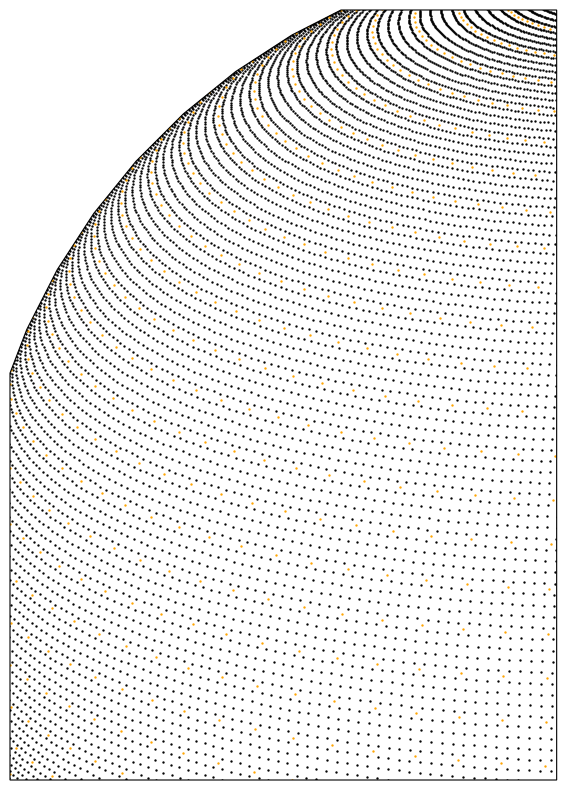

In [80]:
nrows=1
ncols=1
fig, ax = plt.subplots(
    nrows,
    ncols,
    figsize=(ncols*10, nrows*10),
    subplot_kw={"projection": ccrs.Orthographic(central_longitude=-120, central_latitude=20)},
)

for xds, factor, color in zip([gds, gmesh], [10, 5], ["black", "orange"]):
    lon, lat = np.meshgrid(xds.lon, xds.lat)
    #ax.scatter(lon[:factor,:factor], lat[:factor, :factor], c=color)
    ax.scatter(lon, lat, c=color, transform=ccrs.PlateCarree(), s=1/2)
    ax.set_extent([-190, -150, 0, 80], crs=ccrs.PlateCarree())

### Save them out and use anemoi in a separate notebook to combine them

In [82]:
hmesh.to_netcdf(f"latentx4.hrrr15km.trim15-16.nc")
gmesh.to_netcdf(f"latentx4.global1degree.nc")